Matplotlib is building the font cache; this may take a moment.


PyTorch version: 2.7.1
MPS available: True
MPS built: True
Using Apple Silicon MPS


100%|██████████| 9.91M/9.91M [00:01<00:00, 7.25MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 369kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.95MB/s]

Training samples: 60000
Test samples: 10000



/Users/adriansanchez/src/ml_notebooks/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


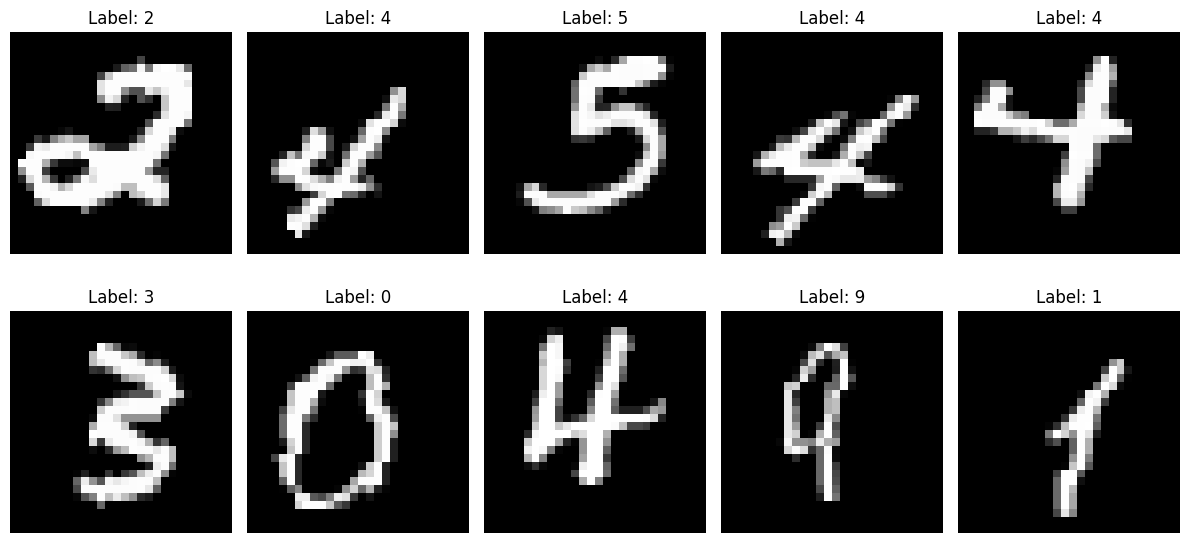

Total parameters: 798,058
Trainable parameters: 798,058


TypeError: __init__() got an unexpected keyword argument 'verbose'

In [2]:
# MNIST CNN Training with PyTorch on Apple M4
# Optimized for Apple Silicon MPS backend

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

# Check for Apple Silicon MPS availability
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# Set device - prioritize MPS for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# Data loaders with optimized settings for Apple Silicon
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize some sample data
def show_samples():
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(10):
        row, col = i // 5, i % 5
        axes[row, col].imshow(images[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f'Label: {labels[i]}')
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

show_samples()

# Define CNN Architecture
class MNISTCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MNISTCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Third convolutional block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.AdaptiveAvgPool2d((3, 3))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third conv block
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout4(x)
        x = self.fc3(x)
        
        return x

# Initialize model
model = MNISTCNN().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        # Update progress bar
        accuracy = 100. * correct / total
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{accuracy:.2f}%'
        })
    
    return running_loss / len(train_loader), 100. * correct / total

# Testing function
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing', leave=False)
        for data, target in progress_bar:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            accuracy = 100. * correct / total
            progress_bar.set_postfix({'Acc': f'{accuracy:.2f}%'})
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    return test_loss, accuracy

# Training loop
num_epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
start_time = time.time()

best_accuracy = 0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Test
    test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(test_acc)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Save best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_mnist_model.pth')
        print(f"New best model saved! Accuracy: {test_acc:.2f}%")
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')
print(f'Best test accuracy: {best_accuracy:.2f}%')

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='red')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(test_accuracies, label='Test Accuracy', color='red')
ax2.set_title('Training and Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate on test set with detailed metrics
def detailed_evaluation(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    return np.array(all_preds), np.array(all_targets)

# Load best model and evaluate
model.load_state_dict(torch.load('best_mnist_model.pth'))
predictions, targets = detailed_evaluation(model, test_loader, device)

# Confusion matrix visualization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=[str(i) for i in range(10)]))

# Show some predictions
def show_predictions(model, test_loader, device, num_samples=12):
    model.eval()
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.ravel()
    
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        predictions = outputs.argmax(dim=1).cpu()
    
    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        pred = predictions[i].item()
        actual = labels[i].item()
        color = 'green' if pred == actual else 'red'
        axes[i].set_title(f'Pred: {pred}, Actual: {actual}', color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, device)

# Model summary and performance metrics
print(f"\nFinal Model Performance:")
print(f"Best Test Accuracy: {best_accuracy:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Model Size: {total_params:,} parameters")
print(f"Device Used: {device}")

# Save training history
training_history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies,
    'best_accuracy': best_accuracy,
    'total_time': total_time
}

torch.save(training_history, 'training_history.pth')
print("\nTraining history saved to 'training_history.pth'")
print("Best model saved to 'best_mnist_model.pth'")